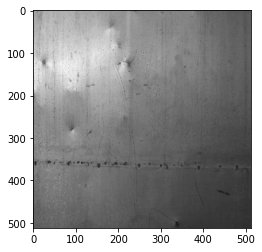

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.filters import rank

img = cv2.imread('/content/1.jpg',0)
img = cv2.resize(img,(512,512))
plt.imshow(img,cmap='gray')

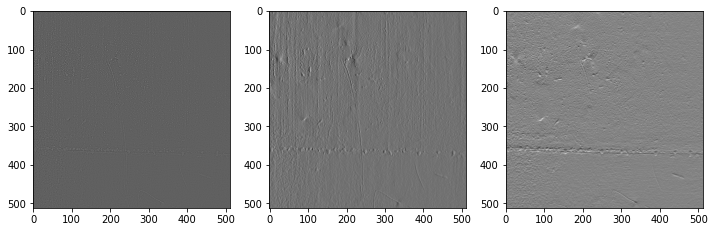

In [46]:
def gaussblur(sigma, Image):
  image2 = cv2.resize(Image, (0, 0), fx=2, fy=2)
  sigma1 = np.sqrt(max((sigma ** 2) - 1, 0.01))
  k = cv2.GaussianBlur(image2, (0, 0), sigmaX=sigma1, sigmaY=sigma1)
  return k
def gradient_image(image1): 
  Output=[]
  Output.append(cv2.Laplacian(image1,cv2.CV_64F))
  Output.append(cv2.Sobel(image1,cv2.CV_64F,1,0,ksize=3))
  Output.append(cv2.Sobel(image1,cv2.CV_64F,0,1,ksize=3))
  return Output
k=gaussblur(0.5,img)

def preproc2(image):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl1 = clahe.apply(img)
  return cl1
cl1 = preproc2(img)
out = gradient_image(cl1)
fig, plot = plt.subplots(1, 3, figsize=(12,9))
plot[0].imshow(out[0],cmap='gray')
plot[1].imshow(out[1],cmap='gray')
plot[2].imshow(out[2],cmap='gray')

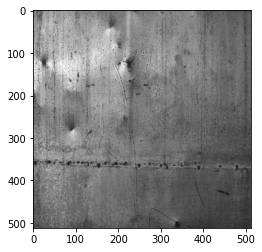

In [47]:
# we find that simple gaussian blur, laplacian will not work for this case. hence we have to use histogram equalization
# Contrast limited adaptive histogram equalization
plt.imshow(cl1,cmap='gray')

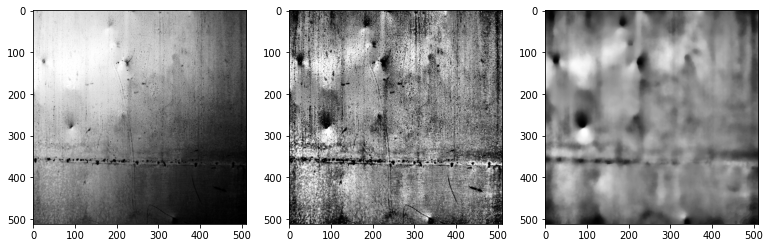

In [56]:
from skimage.morphology import disk
from skimage.filters.rank import median
def hist_eq(img,d1,d2):
  img_rescale = skimage.exposure.equalize_hist(img)
  img_eq = rank.equalize(img, selem=disk(d1))
  noisy_image = img_eq
  noise = np.random.random(noisy_image.shape)
  noisy_image[noise > 0.99] = 255
  noisy_image[noise < 0.01] = 0
  img111 = median(noisy_image, disk(d2))
  return img111, img_eq, img_rescale

img111, img_eq, img_rescale = hist_eq(img,80,9)
fig, plot = plt.subplots(1, 3, figsize=(13,10))
plot[1].imshow(img_eq, cmap='gray')
plot[0].imshow(img_rescale, cmap='gray')
plot[2].imshow(img111, cmap='gray')

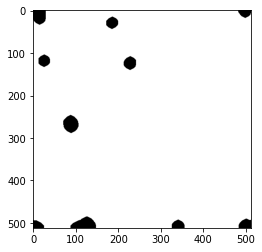

In [66]:
def threshold(imgOverlap,th, N):
  for ii in range (N):
     (thresh, blackAndWhiteImage) = cv2.threshold(imgOverlap, th, 255, cv2.THRESH_BINARY)
     imgBw = blackAndWhiteImage
  return imgBw

def morph(img111,d3):
  kll = threshold(img111, d3, 1)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
  kll2 = cv2.dilate(kll, kernel, iterations = 2)
  kll1 = cv2.erode(kll2, kernel2, iterations = 4)
  #kll1 = cv2.morphologyEx(kll, cv2.MORPH_CLOSE, kernel)
  return kll1

kll1 = morph(img111,25)
plt.imshow(kll1, cmap='gray')

# Regions where dents are present are identified

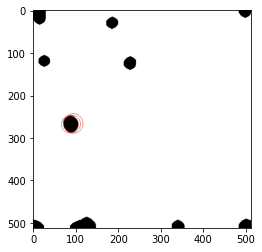

In [50]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

'''
# FOR DETECTING ELLIPSES
result = hough_ellipse(edges, accuracy=1, threshold=40, min_size=1, max_size=None)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()
'''

# FOR DETECTING CIRCLES
def detect_circ(kll1):
  image = kll1
  edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)
  hough_radii = np.arange(20, 35, 3)
  hough_res = hough_circle(edges, hough_radii)

  # Select the most prominent 3 circles
  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3)

  # Drawing them
  image = color.gray2rgb(image)
  k12 = color.gray2rgb(img)
  for center_y, center_x, radius in zip(cy, cx, radii):
      circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
      image[circy, circx] = (220, 20, 20)
  return image

image = detect_circ(kll1)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.imshow(image, cmap=plt.cm.gray)
plt.show()

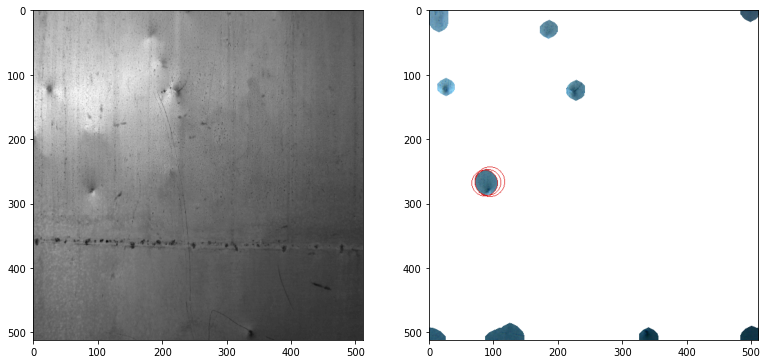

In [77]:
# Load two images
img1 = cv2.imread('1.jpg')
img1 = cv2.resize(img1, (512,512))
img2 = image

# MASKING
def masking(img1,img2):
  rows,cols,columns = img2.shape
  roi = img1[0:rows, 0:cols ]
  img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
  ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  # black-out the area of logo in ROI
  img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

  # Take only region of logo from logo image.
  img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

  # Put logo in ROI and modify the main image
  dst = cv2.add(img1_bg,img2_fg)
  img1[0:rows, 0:cols ] = dst
  return img1
img1 = masking(img1,img2)

fig, plot = plt.subplots(1, 2, figsize=(13,10))
plot[1].imshow(img1, cmap='gray')
plot[0].imshow(img, cmap='gray')

cv2.waitKey(0)
cv2.destroyAllWindows()

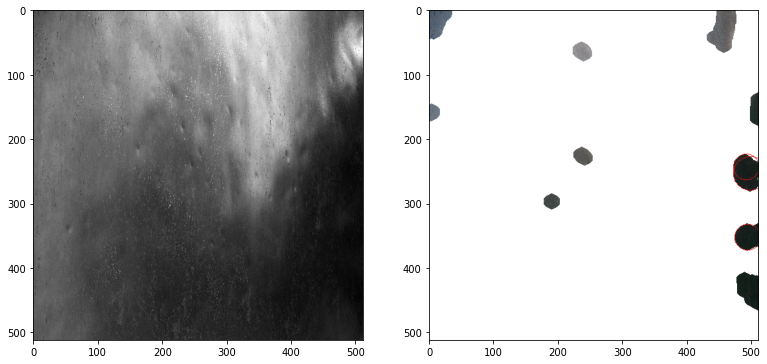

In [75]:
# defining function to identify dents

def dent_identifier(img,img11,d1,d2,d3):
  img111, img_eq, img_rescale = hist_eq(img,d1,d2)
  kll1 = morph(img111,d3)
  image = detect_circ(kll1)
  img1 = masking(img11,image)
  return img1

img112 = cv2.imread('/content/1(2).jpg')
img112 = cv2.resize(img112, (512,512))

img123 = cv2.imread('/content/1(2).jpg',0)
img123 = cv2.resize(img123,(512,512))

kkk = dent_identifier(img123,img112,65,5,40)
fig, plot = plt.subplots(1, 2, figsize=(13,10))
plot[1].imshow(kkk, cmap='gray')
plot[0].imshow(img123, cmap='gray')
cv2.waitKey(0)
cv2.destroyAllWindows()